In [24]:
import numpy as np
from tqdm import tqdm
import os, sys
sys.path.append('/wk171/handsomedong/after_Meeting/')

from utility import load_data, cal_itv_error
from new_fig import cal_interval_rmse
from preprocess.utils_data_collect.terrain_slope import load_shp, mapping

/home/handsomedong/anaconda3/envs/dlra/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = os.path.join(os.getcwd(), "repro_data")
fileList = [os.path.join(os.getcwd(), "repro_data", i) for i in sorted(os.listdir(path)) if "avg" in i]
# model decision
names = ['PONI', 'PONI+TERRAIN']
fileList = [fileList[5], fileList[2]]
fileList

['/wk171/handsomedong/after_Meeting/evaluation/repro_data/BalancedGRUAdvPONIAtten_mt19_dt17_avg.pkl',
 '/wk171/handsomedong/after_Meeting/evaluation/repro_data/BalGRUAdvPONIAtten_addponi_mt20_dt49_avg.pkl']

In [3]:
# LOAD AI
data_loader = load_data(*fileList, file_num = len(fileList))
all_data, target, datetime, = data_loader._return
print(all_data[0].shape)
# LOAD TERRAIN
filename = "/bk2/handsomedong/DLRA_database/terrain_slope/GIS_terrain.shp"
df = load_shp(filename)
target_map, latList, lonList = df.getMap("高程")
new_map, new_lat, new_lon = mapping(latList, lonList, target_map, (120,120))

/wk171/handsomedong/after_Meeting/evaluation/repro_data/BalancedGRUAdvPONIAtten_mt19_dt17_avg.pkl has been loaded.
/wk171/handsomedong/after_Meeting/evaluation/repro_data/BalGRUAdvPONIAtten_addponi_mt20_dt49_avg.pkl has been loaded.
(13087, 1, 3, 120, 120)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43953/43953 [00:01<00:00, 36662.25it/s]

Latitude Range: 24.0625~25.55, Longitude Range: 120.6875~122.175 for cropped TW [120x120]


# eval terrain by altitude

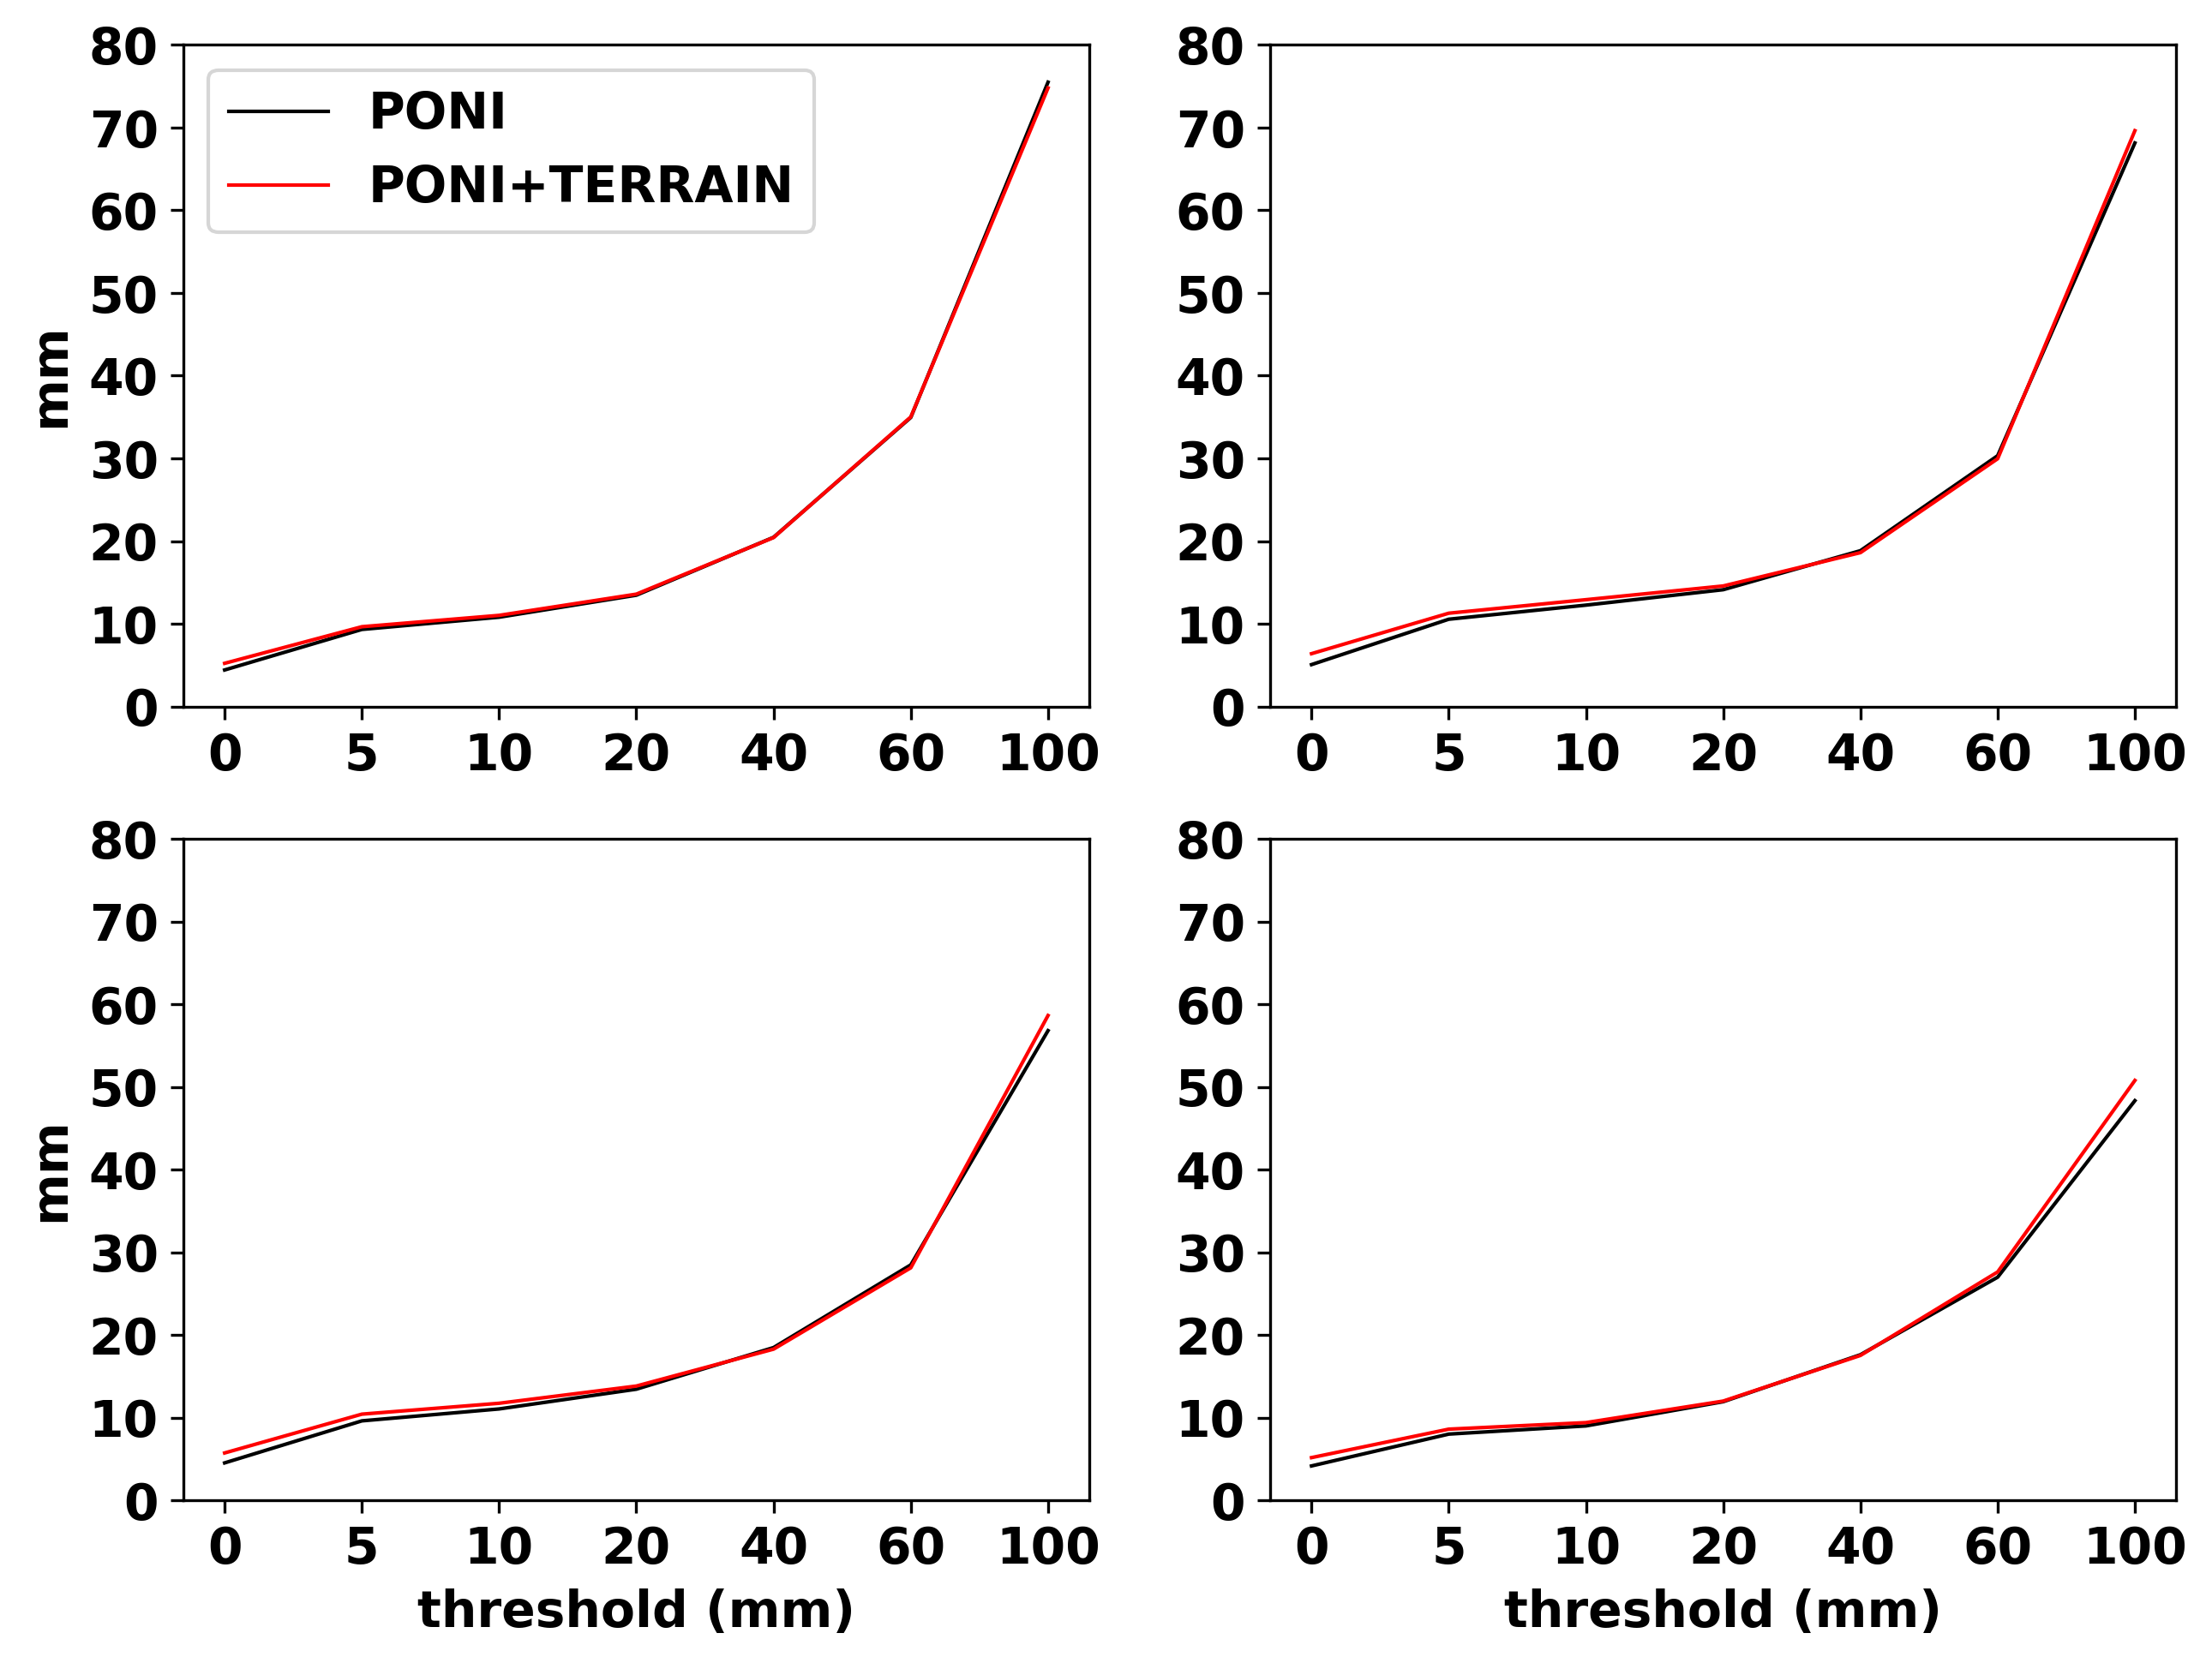

In [68]:
import matplotlib.pyplot as plt
# 0~500, 500~1000, 1000~2000, >2000
terr_thsh = [0, 500, 1000, 2000]
rain_thsh = [0, 5, 10, 20, 40, 60, 100]
n_models = len(all_data)

fig, ax = plt.subplots(int(len(terr_thsh)/2),2, figsize=(10, 7.5), dpi=300, facecolor='w')
for i in range(len(terr_thsh)):
    rmse_results = []
    
    # make filter_terrain
    if i == len(terr_thsh)-1:
        terr_filter = new_map >= terr_thsh[i]
    else:
        terr_filter = (new_map >= terr_thsh[i]) & (new_map < terr_thsh[i+1])
    
    # 3-h accu & filtered 
    tmp_target = np.sum(target, axis=1)# [B, H, W]
    tmp_target = np.where(terr_filter, tmp_target, -99)
    
    # cal rmse for different models
    for j in range(n_models):
        tmp_data = all_data[j].squeeze()
        tmp_data = np.sum(tmp_data, axis=1) # [B, H, W]
        
        rmse_results.append(cal_interval_rmse(tmp_data, tmp_target, rain_thsh))
        del tmp_data
    
    # plot
    ax[i//2, i%2].plot(range(len(rain_thsh)),rmse_results[0],'k',linewidth=1)
    ax[i//2, i%2].plot(range(len(rain_thsh)),rmse_results[1],'r',linewidth=1)
    ax[i//2, i%2].set_xticks(np.arange(len(rain_thsh)))
    ax[i//2, i%2].set_xticklabels(rain_thsh)
    ax[i//2, i%2].set_ylim(0, 80)
    ax[i//2, i%2].set_yticks(np.arange(0,90,10))
    if i//2 != 0:
        ax[i//2, i%2].set_xlabel('threshold (mm)')
    if i%2 == 0:
        ax[i//2, i%2].set_ylabel('mm')
    if i//2 == 0 and i%2 == 0:
        ax[i//2, i%2].legend(names)